In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA

In [89]:
df = pd.read_csv('https://raw.githubusercontent.com/GregaVrbancic/Phishing-Dataset/master/dataset_small.csv')

In [18]:
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3598,0,0,0,0,0,0
1,4,0,0,2,0,0,0,0,0,0,...,1,4,1,3977,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,1,2,1,10788,0,0,0,0,0,0
3,2,0,0,3,0,0,0,0,0,0,...,1,2,1,14339,1,0,0,0,0,1
4,1,1,0,4,0,0,0,0,0,0,...,1,2,1,389,1,1,0,0,0,1


## EDA and Data Check

In [19]:
#no categorical values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 50.1 MB


In [90]:
#no missing values
assert df.isna().agg(sum).sum() == 0

In [91]:
#checking for dulplicate rows
df.duplicated().sum()

1240

In [92]:
#dropping duplicate rows
df = df.drop_duplicates(keep=False)

In [93]:
assert df.duplicated().sum() == 0

In [94]:
df.shape

(56992, 112)

In [95]:
#moderately imbalanced dataset
df.phishing.value_counts(normalize=True)

phishing
1    0.53404
0    0.46596
Name: proportion, dtype: float64

## Variance in dataset sections

The entire dataset was devided into the following sections:
- Dataset attributes based on URL
- Dataset attributes based on Domain URL
- Dataset attributes based on URL directory
- Dataset attributes based on URL file name
- Dataset attributes based on URL parameters
- Dataset attributes based on resolving URL and external services

So it makes sense to check how these sections might be different

In [26]:
df_copy = df.copy()

In [27]:
#Let's create a separate dataframe for each section
df_url = df_copy.iloc[:, :19].assign(email_in_url=df_copy['email_in_url'])
df_domain = df_copy.iloc[:, 19:40]
df_directory = df_copy.iloc[:, 40:58]
df_file = df_copy.iloc[:, 58:76]
df_param = df_copy.iloc[:, 76:96]
df_external = df_copy.iloc[:, 97:111]

In [29]:
#We will exclude the last section from comparision becuase it contains data of a different kind
dataframes = [df_url, df_domain, df_directory, df_file, df_param]
df_names = ['URL', 'Domain', 'Directory', 'File', 'Parameter']

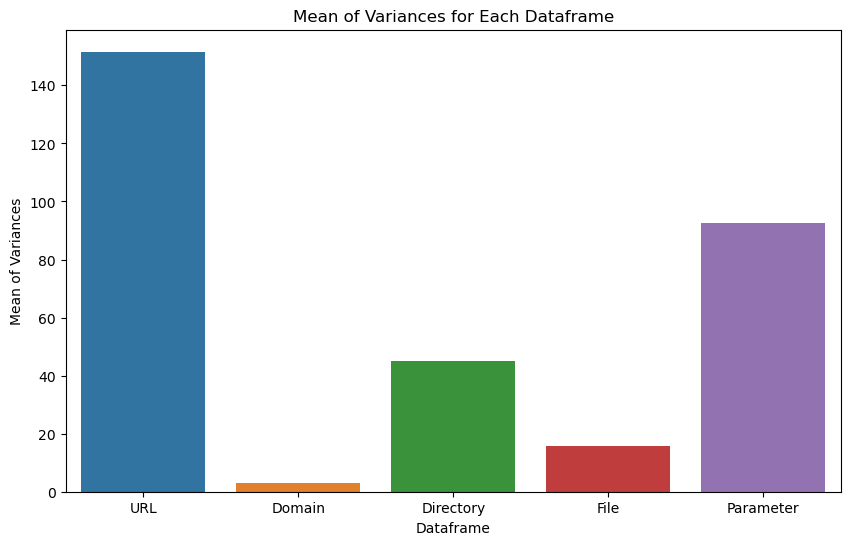

In [30]:
#Let's calculate mean values of variances for all sections and plot the result
results = []
for df_copy, name in zip(dataframes, df_names):
    result = df_copy.var().mean()
    results.append({'Dataframe': name, 'Variance Mean': result})
result_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Dataframe', y='Variance Mean', data=result_df)
plt.title('Mean of Variances for Each Dataframe')
plt.xlabel('Dataframe')
plt.ylabel('Mean of Variances')
plt.show()

In [9]:
#As we can see, the domain section has near zero mean variance which might indicate its less importance

## mutual_info_classif

In [69]:
X = df.drop('phishing', axis=1)
y = df['phishing']

In [33]:
mi_scores = mutual_info_classif(X, y)

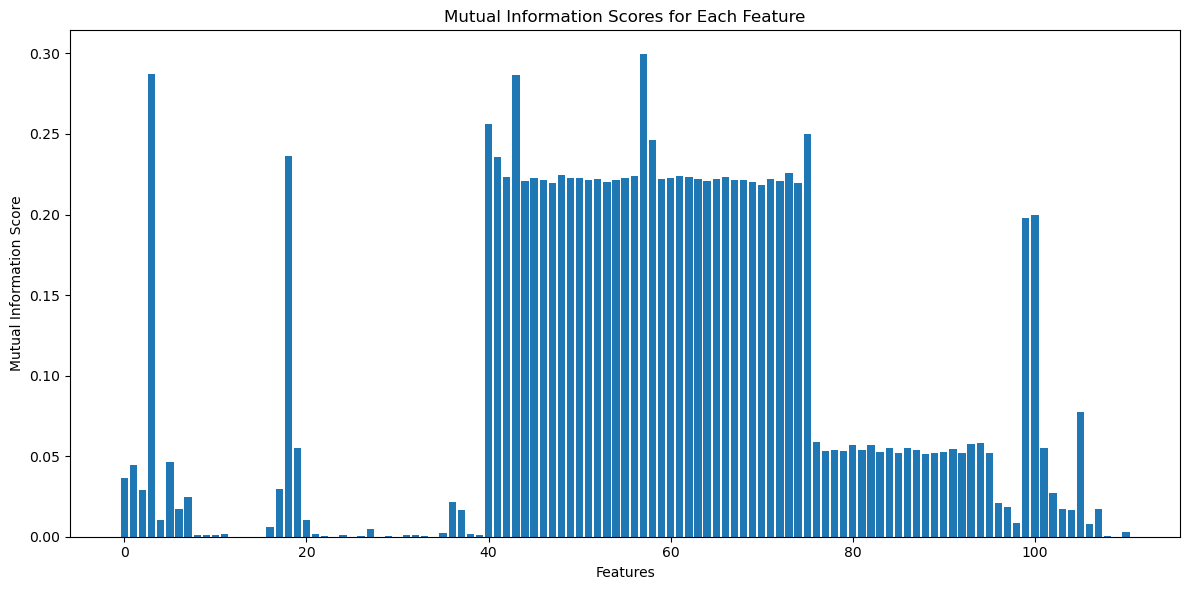

In [35]:
# Create a bar plot of mutual information scores
plt.figure(figsize=(12, 6))
plt.bar(range(len(mi_scores)), mi_scores)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for Each Feature')
#plt.xticks(range(len(mi_scores)), X.columns, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False).reset_index(drop=True)
print("\nFeatures ranked by Mutual Information Score:")
print(mi_df)


Features ranked by Mutual Information Score:
                 Feature  MI_Score
0       directory_length  0.299367
1          qty_slash_url  0.287288
2    qty_slash_directory  0.286405
3      qty_dot_directory  0.256036
4            file_length  0.249879
..                   ...       ...
106         qty_plus_url  0.000000
107     qty_comma_domain  0.000000
108    qty_dollar_domain  0.000000
109  domain_google_index  0.000000
110       qty_dollar_url  0.000000

[111 rows x 2 columns]


In [37]:
mi_df.query('MI_Score > 0.01')

,Feature,MI_Score
0,directory_length,0.299367
1,qty_slash_url,0.287288
2,qty_slash_directory,0.286405
3,qty_dot_directory,0.256036
4,file_length,0.249879
...,...,...
75,qty_nameservers,0.017075
76,qty_mx_servers,0.016863
77,domain_length,0.016574
78,qty_questionmark_url,0.010385


([], [])

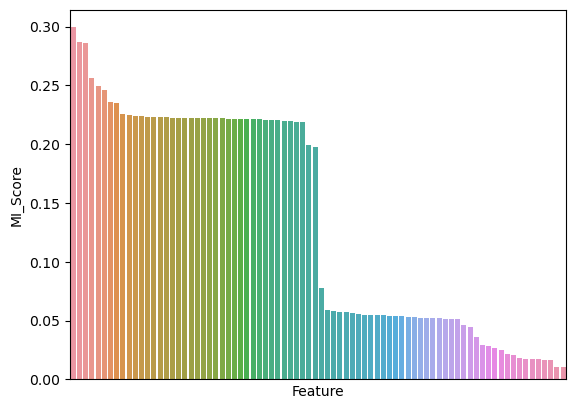

In [39]:
sns.barplot(x='Feature', y='MI_Score', data=mi_df.query('MI_Score > 0.01'))
plt.xticks([])

In [40]:
mi_df.query('MI_Score < 0.01')

,Feature,MI_Score
80,domain_spf,0.008758
81,tls_ssl_certificate,0.008062
82,qty_percent_url,0.005982
83,qty_exclamation_domain,0.004617
84,url_shortened,0.003222
85,qty_percent_domain,0.002253
86,qty_underline_domain,0.001721
87,qty_comma_url,0.001686
88,domain_in_ip,0.001554
89,qty_plus_domain,0.001374


## Multicollinearity

**The dataset has a high degree of multicollinearity, however, we will not do anything about it**

In [42]:
corr_matrix = df.corr()

In [43]:
threshold = 0.8

In [45]:
#Create a mask to ignore self-correlations (diagonal) and lower triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

In [46]:
#Extract pairs of features with correlation greater than the threshold
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                   for i, j in zip(*np.where((np.abs(corr_matrix) > threshold) & mask))]

In [47]:
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

In [51]:
high_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature 1    380 non-null    object 
 1   Feature 2    380 non-null    object 
 2   Correlation  380 non-null    float64
dtypes: float64(1), object(2)
memory usage: 9.0+ KB


## PCA

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [73]:
# Print the number of components selected
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 40


## Data prep

In [96]:
X = df.drop(labels=["phishing"], axis=1)
y = df["phishing"]

In [97]:
#train/test splitting with stratify option
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape

((45593, 111), (11399, 111))

In [98]:
#standard scaling
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## About accuracy metric

For this dataset, a false positive will be observed when a model labels a normal site as malicious. A false negative will be observed when a model labels a malicious site. False negatives are more dangerous as a user will trust a malicious site. Therefore, we will be using recall score.

## Aplying models

**Dummy classifier**

In [99]:
#We will use a sklearn dummy classifier to establish a baseline
dummy_clf = DummyClassifier(strategy="prior")

In [100]:
dummy_clf.fit(X_train_scaled, y_train)

DummyClassifier()

In [101]:
y_pred_test = dummy_clf.predict(X_test_scaled)
y_pred_train = dummy_clf.predict(X_train_scaled)

In [102]:
#the dummy classifer predicts no instance of 1 class, therefore we can't really calculate false negative rate or 
#recall score
np.unique(y_pred_test)

array([1])

In [88]:
#we can look at the classification report to confirm that
report = classification_report(y_test, y_pred_test, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5311
           1       0.53      1.00      0.70      6088

    accuracy                           0.53     11399
   macro avg       0.27      0.50      0.35     11399
weighted avg       0.29      0.53      0.37     11399



**Logistic regression**

In [40]:
log_reg = LogisticRegression(max_iter=10000)

In [41]:
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000)

In [42]:
y_pred_test_log = log_reg.predict(X_test_scaled)
y_pred_train_log = log_reg.predict(X_train_scaled)

In [43]:
recall_test_log = recall_score(y_test, y_pred_test_log)
recall_train_log = recall_score(y_train, y_pred_train_log)

In [49]:
print("Test set recall score: ", round(recall_test_log, 3))
print("Train set recall score: ", round(recall_train_log, 3))

Test set recall score:  0.917
Train set recall score:  0.916


**KNN**

In [45]:
knn = KNeighborsClassifier()

In [46]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [47]:
y_pred_test_knn = knn.predict(X_test_scaled)
y_pred_train_knn = knn.predict(X_train_scaled)

In [50]:
recall_test_knn = recall_score(y_test, y_pred_test_knn)
recall_train_knn = recall_score(y_train, y_pred_train_knn)

In [51]:
print("Test set recall score: ", round(recall_test_knn, 3))
print("Train set recall score: ", round(recall_train_knn, 3))

Test set recall score:  0.933
Train set recall score:  0.949


**Decision Tree**

In [52]:
decision_tree = DecisionTreeClassifier()

In [1]:
#no need for scaling? see snapshot

In [53]:
decision_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [54]:
y_pred_test_tree = decision_tree.predict(X_test_scaled)
y_pred_train_tree = decision_tree.predict(X_train_scaled)

In [55]:
recall_test_tree = recall_score(y_test, y_pred_test_tree)
recall_train_tree = recall_score(y_train, y_pred_train_tree)

In [56]:
print("Test set recall score: ", round(recall_test_tree, 3))
print("Train set recall score: ", round(recall_train_tree, 3))

Test set recall score:  0.93
Train set recall score:  1.0


**SVM**

In [57]:
svc = SVC()

In [58]:
svc.fit(X_train_scaled, y_train)

SVC()

In [59]:
y_pred_test_svm = svc.predict(X_test_scaled)
y_pred_train_svm = svc.predict(X_train_scaled)

In [60]:
recall_test_svm = recall_score(y_test, y_pred_test_svm)
recall_train_svm = recall_score(y_train, y_pred_train_svm)

In [61]:
print("Test set precision score: ", round(recall_test_svm, 3))
print("Train set precision score: ", round(recall_train_svm, 3))

Test set precision score:  0.929
Train set precision score:  0.93


## Tuning the model

In [127]:
param_grid_knn = {
    'n_neighbors': [18, 19, 20, 21, 22],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [128]:
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='recall')

In [129]:
grid_search_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [18, 19, 20, 21, 22],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [130]:
best_knn = grid_search_knn.best_estimator_

In [131]:
y_pred_test_knn_g = best_knn.predict(X_test_scaled)
y_pred_train_knn_g = best_knn.predict(X_train_scaled)

In [132]:
recall_test_knn_g = recall_score(y_test, y_pred_test_knn_g)
recall_train_knn_g = recall_score(y_train, y_pred_train_knn_g)

In [133]:
print("Best parameters found: ", grid_search_knn.best_params_)

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


In [134]:
print("Test set recall score: ", round(recall_test_knn_g, 3))
print("Train set recall score: ", round(recall_train_knn_g, 3))

Test set recall score:  0.931
Train set recall score:  1.0


## Feature selection

In [139]:
sfs = SequentialFeatureSelector(knn, n_features_to_select=10, direction='backward', scoring='recall')

In [143]:
pipeline = Pipeline([
    ('feature_selection', sfs),
    ('KNN', knn)
])

In [144]:
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('feature_selection',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=KNeighborsClassifier(),
                                           n_features_to_select=10,
                                           scoring='recall')),
                ('KNN', KNeighborsClassifier())])

In [145]:
y_pred_test_knn_2 = pipeline.predict(X_test_scaled)
y_pred_train_knn_2 = pipeline.predict(X_train_scaled)

In [146]:
recall_test_knn_2 = recall_score(y_test, y_pred_test_knn_2)
recall_train_knn_2 = recall_score(y_train, y_pred_train_knn_2)

In [147]:
print("Test set recall score: ", round(recall_test_knn_2, 3))
print("Train set recall score: ", round(recall_train_knn_2, 3))

Test set recall score:  0.906
Train set recall score:  0.947


In [148]:
selected_features = sfs.get_support(indices=True)

In [149]:
print(f'Selected Features: {X.columns[selected_features].tolist()}')

Selected Features: ['qty_slash_url', 'qty_dot_domain', 'qty_vowels_domain', 'qty_dot_directory', 'qty_underline_file', 'domain_spf', 'time_domain_activation', 'qty_ip_resolved', 'qty_mx_servers', 'tls_ssl_certificate']
